# Hyperparameter Optimization

Deep-learning models are the state-of-the-art in time series forecasting. They have outperformed statistical and tree-based approaches in recent large-scale competitions, such as the M series, and are being increasingly adopted in industry. However, their performance is greatly affected by the choice of hyperparameters. Selecting the optimal configuration, a process called hyperparameter tuning, is essential to achieve the best performance.

The main steps of hyperparameter tuning are:

 1. Define training and validation sets.
 2. Define search space.
 3. Sample configurations with a search algorithm, train models, and evaluate them on the validation set.
 4. Select and store the best model.

With `Neuralforecast`, we automatize and simplify the hyperparameter tuning process with the `Auto` models. Every model in the library has an `Auto` version (for example, `AutoNHITS`, `AutoTFT`) which can perform automatic hyperparameter selection on default or user-defined search space.

The `Auto` models can be used with two backends: Ray's `Tune` library and `Optuna`, with a user-friendly and simplified API, with most of their capabilities.

In this tutorial, we show in detail how to instantiate and train an `AutoNHITS` model with a custom search space with both `Tune` and `Optuna` backends, install and use `HYPEROPT` search algorithm, and use the model with optimal hyperparameters to forecast.

You can run these experiments using GPU with Google Colab.

<a href="https://colab.research.google.com/github/Nixtla/neuralforecast/blob/main/nbs/examples/Automatic_Hyperparameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Install `Neuralforecast`

In [ ]:
%%capture
!pip install neuralforecast
!pip install hyperopt

## 2. Load Data

In this example we will use the `AirPasengers`, a popular dataset with monthly airline passengers in the US from 1949 to 1960. Load the data, available at our `utils` methods in the required format. See https://nixtla.github.io/neuralforecast/examples/data_format.html for more details on the data input format.

In [ ]:
from neuralforecast.utils import AirPassengersDF

Y_df = AirPassengersDF
Y_df.head()

,unique_id,ds,y
0,1.0,1949-01-31,112.0
1,1.0,1949-02-28,118.0
2,1.0,1949-03-31,132.0
3,1.0,1949-04-30,129.0
4,1.0,1949-05-31,121.0


## 3. Ray's `Tune` backend

First, we show how to use the `Tune` backend. This backend is based on Ray's `Tune` library, which is a scalable framework for hyperparameter tuning. It is a popular library in the machine learning community, and it is used by many companies and research labs. If you plan to use the `Optuna` backend, you can skip this section.

### 3.a Define hyperparameter grid

Each `Auto` model contains a default search space that was extensively tested on multiple large-scale datasets. Additionally, users can define specific search spaces tailored for particular datasets and tasks.

First, we create a custom search space for the `AutoNHITS` model. Search spaces are specified with dictionaries, where keys corresponds to the model's hyperparameter and the value is a `Tune` function to specify how the hyperparameter will be sampled. For example, use `randint` to sample integers uniformly, and `choice` to sample values of a list.

In the following example we are optimizing the `learning_rate` and two `NHITS` specific hyperparameters: `n_pool_kernel_size` and `n_freq_downsample`. Additionaly, we use the search space to modify default hyperparameters, such as `max_steps` and `val_check_steps`. 

In [ ]:
from ray import tune

In [ ]:
nhits_config = {
       "max_steps": 100,                                                         # Number of SGD steps
       "input_size": 24,                                                         # Size of input window
       "learning_rate": tune.loguniform(1e-5, 1e-1),                             # Initial Learning rate
       "n_pool_kernel_size": tune.choice([[2, 2, 2], [16, 8, 1]]),               # MaxPool's Kernelsize
       "n_freq_downsample": tune.choice([[168, 24, 1], [24, 12, 1], [1, 1, 1]]), # Interpolation expressivity ratios
       "val_check_steps": 50,                                                    # Compute validation every 50 steps
       "random_seed": tune.randint(1, 10),                                       # Random seed
    }

:::{.callout-important}
Configuration dictionaries are not interchangeable between models since they have different hyperparameters. Refer to https://nixtla.github.io/neuralforecast/models.html for a complete list of each model's hyperparameters.
:::

### 3.b Instantiate `Auto` model

To instantiate an `Auto` model you need to define:

* `h`: forecasting horizon.
* `loss`: training and validation loss from `neuralforecast.losses.pytorch`.
* `config`: hyperparameter search space. If `None`, the `Auto` class will use a pre-defined suggested hyperparameter space.
* `search_alg`: search algorithm (from `tune.search`), default is random search. Refer to https://docs.ray.io/en/latest/tune/api_docs/suggestion.html for more information on the different search algorithm options.
* `backend`: backend to use, default is `ray`. If `optuna`, the `Auto` class will use the `Optuna` backend.
* `num_samples`: number of configurations explored.

In this example we set horizon `h` as 12, use the `MAE` loss for training and validation, and use the `HYPEROPT` search algorithm. 

In [ ]:
from ray.tune.search.hyperopt import HyperOptSearch
from neuralforecast.losses.pytorch import MAE
from neuralforecast.auto import AutoNHITS

In [ ]:
model = AutoNHITS(h=12,
                  loss=MAE(),
                  config=nhits_config,
                  search_alg=HyperOptSearch(),
                  backend='ray',
                  num_samples=10)

:::{.callout-tip}
The number of samples, `num_samples`, is a crucial parameter! Larger values will usually produce better results as we explore more configurations in the search space, but it will increase training times. Larger search spaces will usually require more samples. As a general rule, we recommend setting `num_samples` higher than 20. We set 10 in this example for demonstration purposes.
:::

### 3.c Train model and predict with `Core` class

Next, we use the `Neuralforecast` class to train the `Auto` model. In this step, `Auto` models will automatically perform hyperparamter tuning training multiple models with different hyperparameters, producing the forecasts on the validation set, and evaluating them. The best configuration is selected based on the error on a validation set. Only the best model is stored and used during inference.

In [ ]:
from neuralforecast import NeuralForecast

Use the `val_size` parameter of the `fit` method to control the length of the validation set. In this case we set the validation set as twice the forecasting horizon.

In [ ]:
%%capture
nf = NeuralForecast(models=[model], freq='M')
nf.fit(df=Y_df, val_size=24)

Global seed set to 8


The results of the hyperparameter tuning are available in the `results` attribute of the `Auto` model. Use the `get_dataframe` method to get the results in a pandas dataframe.

In [ ]:
results = nf.models[0].results.get_dataframe()
results.head()

,loss,time_this_iter_s,done,timesteps_total,episodes_total,training_iteration,trial_id,experiment_id,date,timestamp,...,config/input_size,config/learning_rate,config/loss,config/max_steps,config/n_freq_downsample,config/n_pool_kernel_size,config/random_seed,config/val_check_steps,config/valid_loss,logdir
0,21.173204,3.645993,False,NaN,NaN,2,e20dbd9b,f62650f116914e18889bb96963c6b202,2023-10-03_11-19-14,1696346354,...,24,0.000415,MAE(),100,"[168, 24, 1]","[16, 8, 1]",7,50,MAE(),/Users/cchallu/ray_results/_train_tune_2023-10...
1,33.843426,3.756614,False,NaN,NaN,2,75e09199,f62650f116914e18889bb96963c6b202,2023-10-03_11-19-22,1696346362,...,24,0.000068,MAE(),100,"[24, 12, 1]","[16, 8, 1]",4,50,MAE(),/Users/cchallu/ray_results/_train_tune_2023-10...
2,17.750280,8.573898,False,NaN,NaN,2,0dc5925a,f62650f116914e18889bb96963c6b202,2023-10-03_11-19-36,1696346376,...,24,0.001615,MAE(),100,"[1, 1, 1]","[2, 2, 2]",8,50,MAE(),/Users/cchallu/ray_results/_train_tune_2023-10...
3,24.573055,6.987517,False,NaN,NaN,2,352e03ff,f62650f116914e18889bb96963c6b202,2023-10-03_11-19-50,1696346390,...,24,0.003405,MAE(),100,"[1, 1, 1]","[2, 2, 2]",5,50,MAE(),/Users/cchallu/ray_results/_train_tune_2023-10...
4,474221.937500,4.912362,False,NaN,NaN,2,289bdd5e,f62650f116914e18889bb96963c6b202,2023-10-03_11-20-00,1696346400,...,24,0.080117,MAE(),100,"[168, 24, 1]","[16, 8, 1]",5,50,MAE(),/Users/cchallu/ray_results/_train_tune_2023-10...


Next, we use the `predict` method to forecast the next 12 months using the optimal hyperparameters.

In [ ]:
Y_hat_df = nf.predict()
Y_hat_df = Y_hat_df.reset_index()
Y_hat_df.head()

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.97it/s]


,unique_id,ds,AutoNHITS
0,1.0,1961-01-31,442.346680
1,1.0,1961-02-28,439.409821
2,1.0,1961-03-31,477.709930
3,1.0,1961-04-30,503.884064
4,1.0,1961-05-31,521.344421


## 4. `Optuna` backend

In this section we show how to use the `Optuna` backend. `Optuna` is a lightweight and versatile platform for hyperparameter optimization. If you plan to use the `Tune` backend, you can skip this section.

### 4.a Define hyperparameter grid

Each `Auto` model contains a default search space that was extensively tested on multiple large-scale datasets. Additionally, users can define specific search spaces tailored for particular datasets and tasks.

First, we create a custom search space for the `AutoNHITS` model. Search spaces are specified with a function that returns a dictionary, where keys corresponds to the model's hyperparameter and the value is a `suggest` function to specify how the hyperparameter will be sampled. For example, use `suggest_int` to sample integers uniformly, and `suggest_categorical` to sample values of a list. See https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html for more details.

In the following example we are optimizing the `learning_rate` and two `NHITS` specific hyperparameters: `n_pool_kernel_size` and `n_freq_downsample`. Additionaly, we use the search space to modify default hyperparameters, such as `max_steps` and `val_check_steps`. 

In [ ]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING) # Use this to disable training prints from optuna

In [ ]:
def config_nhits(trial):
    return {
        "max_steps": 100,                                                                                               # Number of SGD steps
        "input_size": 24,                                                                                               # Size of input window
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-1),                                         # Initial Learning rate
        "n_pool_kernel_size": trial.suggest_categorical("n_pool_kernel_size", [[2, 2, 2], [16, 8, 1]]),                 # MaxPool's Kernelsize
        "n_freq_downsample": trial.suggest_categorical("n_freq_downsample", [[168, 24, 1], [24, 12, 1], [1, 1, 1]]),    # Interpolation expressivity ratios
        "val_check_steps": 50,                                                                                          # Compute validation every 50 steps
        "random_seed": trial.suggest_int("random_seed", 1, 10),                                                         # Random seed
    }

### 4.b Instantiate `Auto` model

To instantiate an `Auto` model you need to define:

* `h`: forecasting horizon.
* `loss`: training and validation loss from `neuralforecast.losses.pytorch`.
* `config`: hyperparameter search space. If `None`, the `Auto` class will use a pre-defined suggested hyperparameter space.
* `search_alg`: search algorithm (from `optuna.samplers`), default is TPESampler (Tree-structured Parzen Estimator). Refer to https://optuna.readthedocs.io/en/stable/reference/samplers/index.html for more information on the different search algorithm options.
* `backend`: backend to use, default is `ray`. If `optuna`, the `Auto` class will use the `Optuna` backend.
* `num_samples`: number of configurations explored.

In [ ]:
model = AutoNHITS(h=12,
                  loss=MAE(),
                  config=config_nhits,
                  search_alg=optuna.samplers.TPESampler(),
                  backend='optuna',
                  num_samples=10)

:::{.callout-important}
Configuration dictionaries and search algorithms for `Tune` and `Optuna` are not interchangeable! Use the appropriate type of search algorithm and custom configuration dictionary for each backend.
:::

### 4.c Train model and predict with `Core` class

Use the `val_size` parameter of the `fit` method to control the length of the validation set. In this case we set the validation set as twice the forecasting horizon.

In [ ]:
%%capture
nf = NeuralForecast(models=[model], freq='M')
nf.fit(df=Y_df, val_size=24)

Global seed set to 6
Global seed set to 6
Global seed set to 1
Global seed set to 1
Global seed set to 7
Global seed set to 4
Global seed set to 9
Global seed set to 8
Global seed set to 7
Global seed set to 7
Global seed set to 6


The results of the hyperparameter tuning are available in the `results` attribute of the `Auto` model. Use the `trials_dataframe` method to get the results in a pandas dataframe.

In [ ]:
results = nf.models[0].results.trials_dataframe()
results

,number,value,datetime_start,datetime_complete,duration,params_learning_rate,params_n_freq_downsample,params_n_pool_kernel_size,params_random_seed,user_attrs_ALL_PARAMS,state
0,0,7.257883e+07,2023-10-03 11:20:55.218656,2023-10-03 11:21:03.084276,0 days 00:00:07.865620,0.063594,"[1, 1, 1]","[2, 2, 2]",6,"{'max_steps': 100, 'input_size': 24, 'learning...",COMPLETE
1,1,1.942069e+01,2023-10-03 11:21:03.084708,2023-10-03 11:21:11.257456,0 days 00:00:08.172748,0.000425,"[168, 24, 1]","[2, 2, 2]",6,"{'max_steps': 100, 'input_size': 24, 'learning...",COMPLETE
2,2,9.739689e+11,2023-10-03 11:21:11.258083,2023-10-03 11:21:19.065551,0 days 00:00:07.807468,0.075866,"[168, 24, 1]","[2, 2, 2]",1,"{'max_steps': 100, 'input_size': 24, 'learning...",COMPLETE
3,3,3.989237e+04,2023-10-03 11:21:19.065988,2023-10-03 11:21:27.578646,0 days 00:00:08.512658,0.020554,"[24, 12, 1]","[2, 2, 2]",1,"{'max_steps': 100, 'input_size': 24, 'learning...",COMPLETE
4,4,1.443079e+03,2023-10-03 11:21:27.579112,2023-10-03 11:21:35.763104,0 days 00:00:08.183992,0.027780,"[24, 12, 1]","[16, 8, 1]",7,"{'max_steps': 100, 'input_size': 24, 'learning...",COMPLETE
5,5,2.354673e+01,2023-10-03 11:21:35.763652,2023-10-03 11:21:44.838978,0 days 00:00:09.075326,0.000176,"[24, 12, 1]","[2, 2, 2]",4,"{'max_steps': 100, 'input_size': 24, 'learning...",COMPLETE
6,6,5.158909e+01,2023-10-03 11:21:44.839487,2023-10-03 11:21:55.577230,0 days 00:00:10.737743,0.000018,"[24, 12, 1]","[2, 2, 2]",9,"{'max_steps': 100, 'input_size': 24, 'learning...",COMPLETE
7,7,7.657581e+01,2023-10-03 11:21:55.578412,2023-10-03 11:22:05.263415,0 days 00:00:09.685003,0.017256,"[168, 24, 1]","[2, 2, 2]",8,"{'max_steps': 100, 'input_size': 24, 'learning...",COMPLETE
8,8,1.957761e+01,2023-10-03 11:22:05.263939,2023-10-03 11:22:14.527842,0 days 00:00:09.263903,0.004017,"[24, 12, 1]","[2, 2, 2]",7,"{'max_steps': 100, 'input_size': 24, 'learning...",COMPLETE
9,9,3.355409e+01,2023-10-03 11:22:14.528438,2023-10-03 11:22:23.752345,0 days 00:00:09.223907,0.000065,"[1, 1, 1]","[16, 8, 1]",7,"{'max_steps': 100, 'input_size': 24, 'learning...",COMPLETE


Next, we use the `predict` method to forecast the next 12 months using the optimal hyperparameters.

In [ ]:
Y_hat_df_optuna = nf.predict()
Y_hat_df_optuna = Y_hat_df_optuna.reset_index()
Y_hat_df_optuna.head()

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.75it/s]


,unique_id,ds,AutoNHITS
0,1.0,1961-01-31,445.272858
1,1.0,1961-02-28,469.633423
2,1.0,1961-03-31,475.265289
3,1.0,1961-04-30,483.228516
4,1.0,1961-05-31,516.583496


## 5. Plots

Finally, we compare the forecasts produced by the `AutoNHITS` model with both backends.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

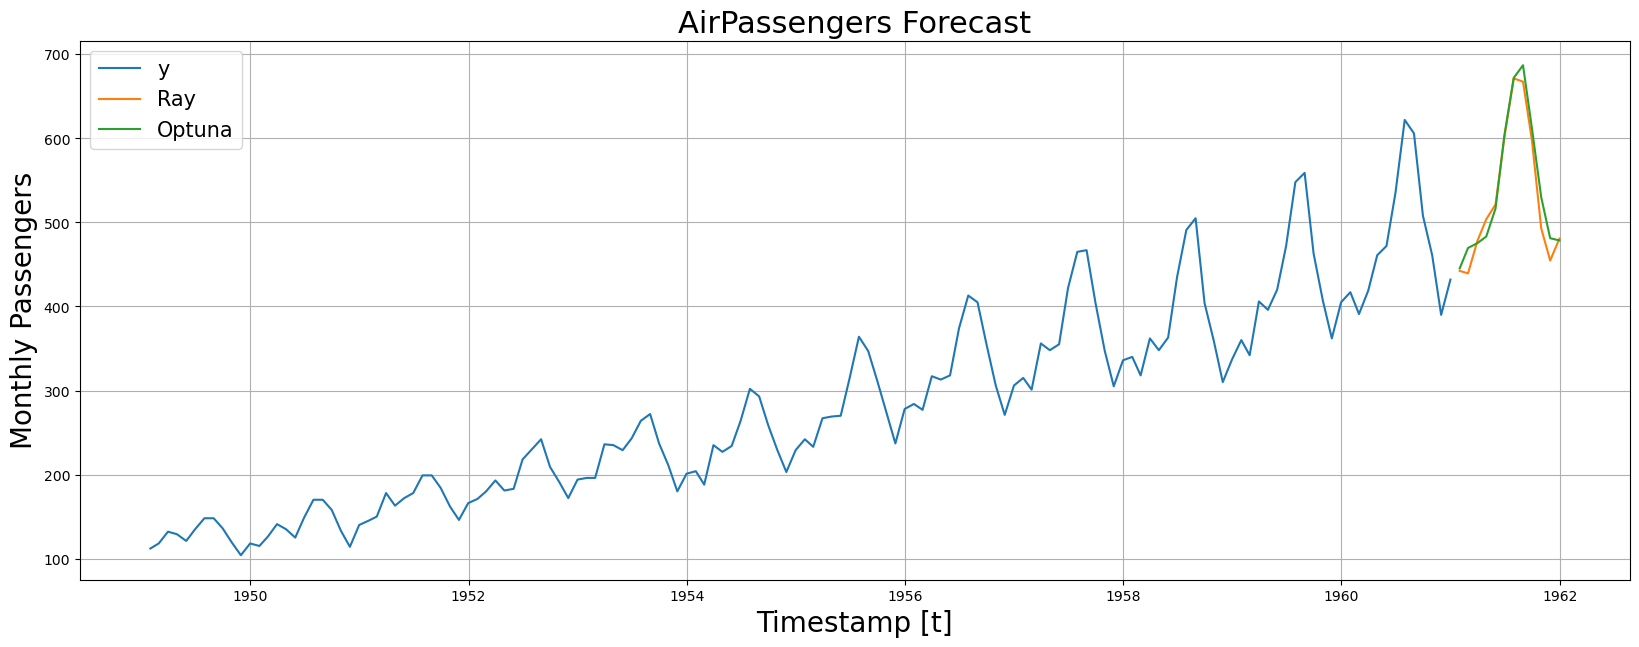

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
plot_df = pd.concat([Y_df, Y_hat_df]).reset_index()

plt.plot(plot_df['ds'], plot_df['y'], label='y')
plt.plot(plot_df['ds'], plot_df['AutoNHITS'], label='Ray')
plt.plot(Y_hat_df_optuna['ds'], Y_hat_df_optuna['AutoNHITS'], label='Optuna')

ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

### References
- [Cristian Challu, Kin G. Olivares, Boris N. Oreshkin, Federico Garza, Max Mergenthaler-Canseco, Artur Dubrawski (2021). NHITS: Neural Hierarchical Interpolation for Time Series Forecasting. Accepted at AAAI 2023.](https://arxiv.org/abs/2201.12886)
- [James Bergstra, Remi Bardenet, Yoshua Bengio, and Balazs Kegl (2011). "Algorithms for Hyper-Parameter Optimization". In: Advances in Neural Information Processing Systems. url: https://proceedings.neurips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf](https://proceedings.neurips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf)
- [Kirthevasan Kandasamy, Karun Raju Vysyaraju, Willie Neiswanger, Biswajit Paria, Christopher R. Collins, Jeff Schneider, Barnabas Poczos, Eric P. Xing (2019). "Tuning Hyperparameters without Grad Students: Scalable and Robust Bayesian Optimisation with Dragonfly". Journal of Machine Learning Research. url: https://arxiv.org/abs/1903.06694](https://arxiv.org/abs/1903.06694)
- [Lisha Li, Kevin Jamieson, Giulia DeSalvo, Afshin Rostamizadeh, Ameet Talwalkar (2016). "Hyperband: A Novel Bandit-Based Approach to Hyperparameter Optimization". Journal of Machine Learning Research. url: https://arxiv.org/abs/1603.06560](https://arxiv.org/abs/1603.06560)